In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
image_folder = "/content/drive/MyDrive/skin_cancer_lesions/HAM10000_all_images"
metadata_path = "/content/drive/MyDrive/skin_cancer_lesions/HAM10000_metadata.csv"


In [ ]:
import pandas as pd
import os

df = pd.read_csv(metadata_path)
df['image_path'] = df['image_id'].apply(lambda x: os.path.join(image_folder, f"{x}.jpg"))
df = df[df['image_path'].apply(os.path.exists)]


In [ ]:
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.utils import to_categorical

le = LabelEncoder()
df['label_encoded'] = le.fit_transform(df['dx'])
y = to_categorical(df['label_encoded'], num_classes=7)


In [ ]:
from PIL import Image
import numpy as np
from tqdm import tqdm  # progress bar

IMG_SIZE = 128

def process_image(path):
    img = Image.open(path).resize((IMG_SIZE, IMG_SIZE))
    img_array = np.array(img)
    if img_array.shape == (IMG_SIZE, IMG_SIZE):  # grayscale
        img_array = np.stack((img_array,)*3, axis=-1)
    elif img_array.shape[2] == 4:  # RGBA
        img_array = img_array[:, :, :3]
    return img_array / 255.0

# Get paths
image_paths = df['image_path'].values

# Use a loop instead of apply
#X_128 = np.array([process_image(p) for p in tqdm(image_paths)])

# Save preprocessed images for reuse
#np.save('/content/drive/MyDrive/skin_cancer_lesions/X_128.npy', X_128)


In [ ]:
X_128 = np.load('/content/drive/MyDrive/skin_cancer_lesions/X_128.npy')


In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(
    X_128, y, test_size=0.2, random_state=42, stratify=y)

print("Train shape:", X_train.shape)
print("Val shape:", X_val.shape)


Train shape: (8012, 128, 128, 3)
Val shape: (2003, 128, 128, 3)


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

BATCH_SIZE = 64

train_gen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True
).flow(X_train, y_train, batch_size=BATCH_SIZE)

val_gen = ImageDataGenerator().flow(X_val, y_val, batch_size=BATCH_SIZE)


In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam

l2_reg = 0.001

model = Sequential([
    Conv2D(16, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg), input_shape=(128, 128, 3)),
    MaxPooling2D(2, 2),

    Conv2D(32, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D(2, 2),

    Conv2D(64, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D(2, 2),

    Conv2D(128, (3, 3), activation='relu', kernel_regularizer=l2(l2_reg)),
    MaxPooling2D(2, 2),

    Flatten(),
    Dense(64, activation='relu', kernel_regularizer=l2(l2_reg)),
    Dropout(0.5),
    Dense(7, activation='softmax')  # 7 classes
])

# Adam optimizer with learning rate = 0.001
optimizer = Adam(learning_rate=0.001)

model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

checkpoint_path = "/content/drive/MyDrive/skin_cancer_lesions/best_model_128.keras"

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint(filepath=checkpoint_path, save_best_only=True),
    ReduceLROnPlateau(monitor='val_loss', patience=3, factor=0.5, verbose=1)
]


In [ ]:
checkpoint_path = "/content/drive/MyDrive/skin_cancer_lesions/best_model_128.keras"


In [ ]:
import pickle

# Train the model and save history
history = model.fit(
    train_gen,
    validation_data=val_gen,
    epochs=50,
    callbacks=callbacks
)

# Save training history to reuse later
with open("/content/drive/MyDrive/skin_cancer_lesions/training_history.pkl", "wb") as f:
    pickle.dump(history.history, f)


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 46s 303ms/step - accuracy: 0.6419 - loss: 1.3699 - val_accuracy: 0.6695 - val_loss: 1.0500 - learning_rate: 0.0010
Epoch 2/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 253ms/step - accuracy: 0.6776 - loss: 1.0846 - val_accuracy: 0.6695 - val_loss: 0.9886 - learning_rate: 0.0010
Epoch 3/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 34s 266ms/step - accuracy: 0.6683 - loss: 1.0354 - val_accuracy: 0.6695 - val_loss: 0.9709 - learning_rate: 0.0010
Epoch 4/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 31s 249ms/step - accuracy: 0.6683 - loss: 1.0052 - val_accuracy: 0.6695 - val_loss: 0.9131 - learning_rate: 0.0010
Epoch 5/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 32s 256ms/step - accuracy: 0.6708 - loss: 0.9543 - val_accuracy: 0.6700 - val_loss: 0.9061 - learning_rate: 0.0010
Epoch 6/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 33s 260ms/step - accuracy: 0.6780 - loss: 0.9409 - val_accuracy: 0.6740 - val_loss: 0.8876 - learning_rate: 0.0010
Epoch 7/50
126/126 ━━━━━━━━━━━━━━━━━━━━ 40s 256ms/step - accuracy: 0.6

In [ ]:
model.save("/content/drive/MyDrive/skin_cancer_lesions/final_model_skin_cancer.keras")

In [ ]:
from tensorflow.keras.models import load_model
model = load_model(checkpoint_path)

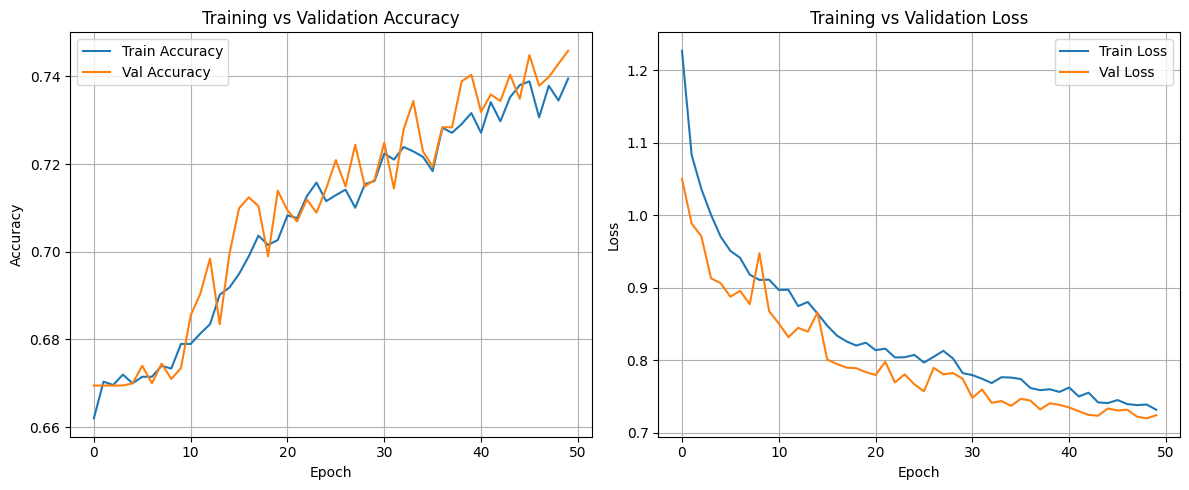

In [ ]:
import pickle
import matplotlib.pyplot as plt

# Load history from Drive
with open("/content/drive/MyDrive/skin_cancer_lesions/training_history.pkl", "rb") as f:
    history_dict = pickle.load(f)

# Plot Accuracy and Loss
plt.figure(figsize=(12, 5))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history_dict['accuracy'], label='Train Accuracy')
plt.plot(history_dict['val_accuracy'], label='Val Accuracy')
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title("Training vs Validation Accuracy")
plt.legend()
plt.grid(True)

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history_dict['loss'], label='Train Loss')
plt.plot(history_dict['val_loss'], label='Val Loss')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Training vs Validation Loss")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, accuracy_score

# Predict labels
y_pred_probs = model.predict(X_val)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_val, axis=1)

# Print report
print(classification_report(y_true, y_pred, target_names=le.classes_))


# Print overall accuracy
accuracy = accuracy_score(y_true, y_pred)
print(f"Validation Accuracy: {accuracy * 100:.2f}%")

63/63 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step
              precision    recall  f1-score   support

       akiec       0.62      0.15      0.25        65
         bcc       0.47      0.55      0.51       103
         bkl       0.45      0.38      0.41       220
          df       0.00      0.00      0.00        23
         mel       0.53      0.24      0.33       223
          nv       0.81      0.95      0.88      1341
        vasc       0.64      0.50      0.56        28

    accuracy                           0.74      2003
   macro avg       0.50      0.40      0.42      2003
weighted avg       0.71      0.74      0.71      2003

Validation Accuracy: 74.29%


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


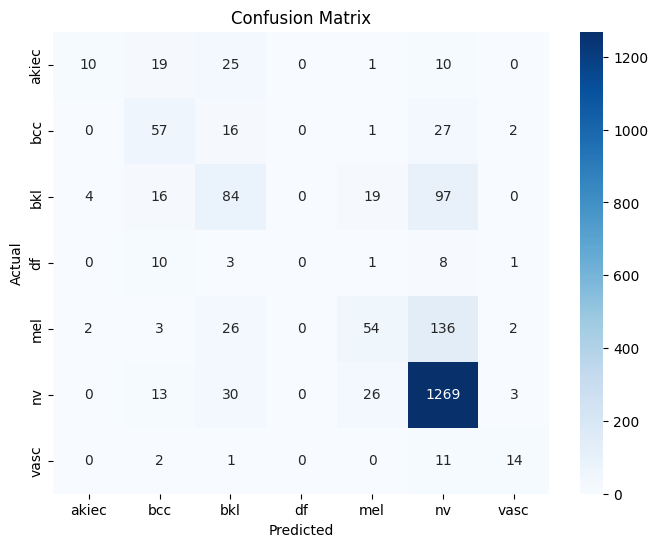

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


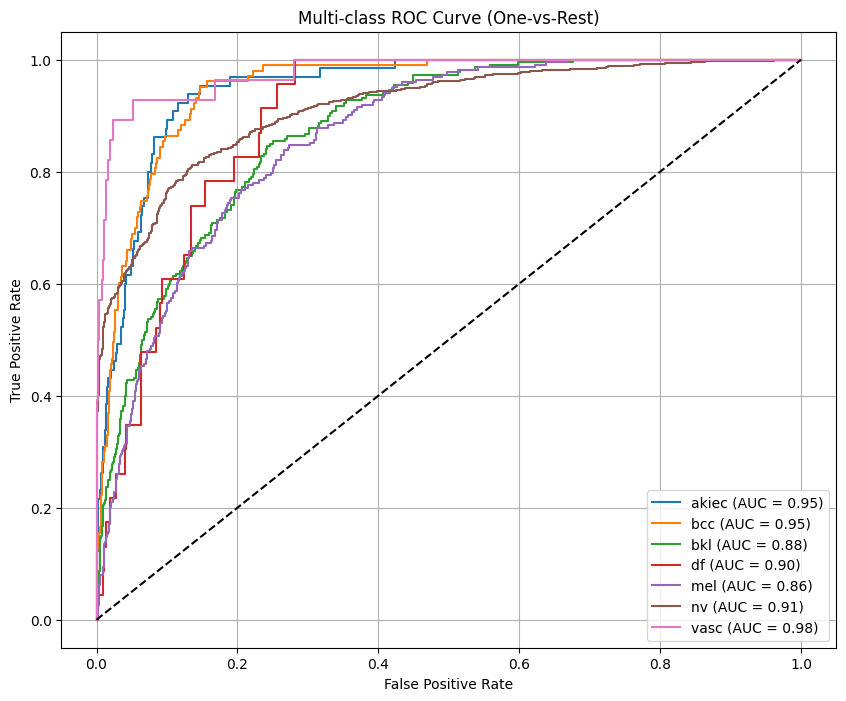

In [ ]:
from sklearn.metrics import roc_curve, auc
from sklearn.preprocessing import label_binarize
import matplotlib.pyplot as plt

# Binarize true labels (7 classes)
y_true_bin = label_binarize(y_true, classes=list(range(7)))

plt.figure(figsize=(10, 8))

# Plot ROC curve for each class
for i in range(7):
    fpr, tpr, _ = roc_curve(y_true_bin[:, i], y_pred_probs[:, i])
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f"{le.classes_[i]} (AUC = {roc_auc:.2f})")

# Plot chance line
plt.plot([0, 1], [0, 1], 'k--')

plt.title("Multi-class ROC Curve (One-vs-Rest)")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend(loc='lower right')
plt.grid(True)
plt.show()


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


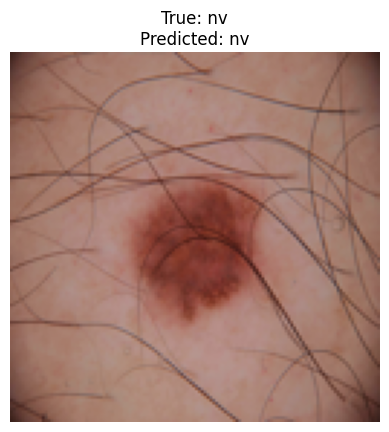

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step


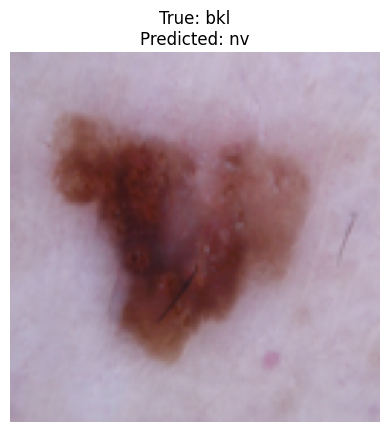

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


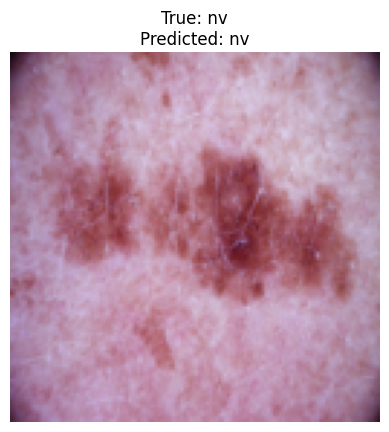

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step


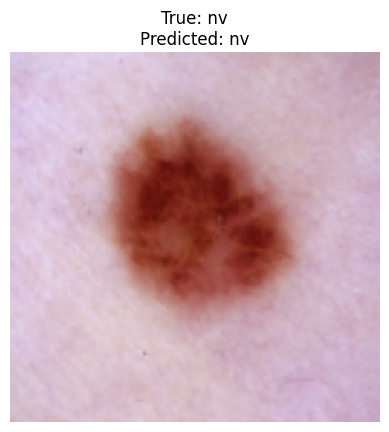

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


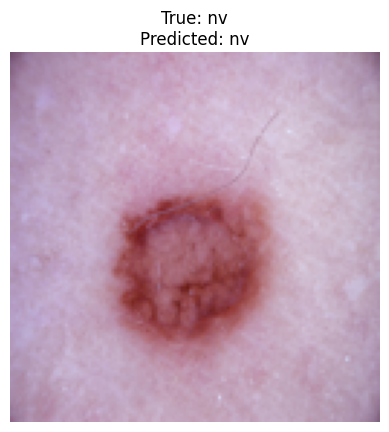

In [ ]:
import matplotlib.pyplot as plt

# Pick 5 random indices from validation set
indices = np.random.choice(len(X_val), 5, replace=False)

for i in indices:
    image = X_val[i]
    true_class = np.argmax(y_val[i])
    predicted_class = np.argmax(model.predict(np.expand_dims(image, axis=0)))

    plt.imshow(image)
    plt.axis("off")
    plt.title(f"True: {le.classes_[true_class]}\nPredicted: {le.classes_[predicted_class]}")
    plt.show()
